<div class="markdown-google-sans">

## <strong>Импорт необходимых библиотек, модели для обучения, а также распаковка набора данных</strong>
</div>

In [1]:
from IPython.display import clear_output 
import cv2
!pip3 install google-colab
from google.colab.patches import cv2_imshow
clear_output()

In [2]:
# Скачивание репозитория с YOLOv5 и необходимых библиотек для работы модели
!git clone https://github.com/ultralytics/yolov5
!pip install -r ./yolov5/requirements.txt
clear_output()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Создаём файл для собственной структуры датасета
!touch ./yolov5/data/custom.yaml

# Запишите в созданный файл (изображение ниже) следующий текст
# для этого можно просто двойным нажатием ЛКМ открыть его, вставить информацию
# и сохранить сочетанием ctrl+s
# Примерная структура датасета. В случае если называете директории по другому, измените их название
"""
train: ../weapon_data/images/train/ 
val:  ../weapon_data/images/val/
test: ../weapon_data/images/test/
# number of classes,
nc: 1,
# class names,
names: ["weapon"]
"""

# Записываем в созданный ранее файл структуру датасете
my_file = open('yolov5/data/custom.yaml','w+')
my_file.write('train: ../weapon_data/images/train/ \nval:  ../weapon_data/images/val/ \ntest: ../weapon_data/images/test/ \n# number of classes \nnc: 1 \n# class names \nnames: ["weapon"]')

166

In [7]:
# Проверка записи в файл структуры. Если вывод пустой, повторно запустите предыдущую ячейку
my_file.readlines()

['train: ../weapon_data/images/train/ \n',
 'val:  ../weapon_data/images/val/ \n',
 'test: ../weapon_data/images/test/ \n',
 '# number of classes \n',
 'nc: 1 \n',
 '# class names \n',
 'names: ["weapon"]']

In [8]:
!pip install imageio
!pip install imutils
clear_output()

In [9]:
import random
from PIL import Image, ImageDraw
import numpy as np
from numpy import int64
import matplotlib.pyplot as plt
import os
import glob
from imageio import imread
import cv2
from google.colab.patches import cv2_imshow
import imutils
import json

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

import torch
from IPython.display import Image
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

<div class="markdown-google-sans">

## <strong>Предобработка датасета</strong>
</div>

In [10]:
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

In [11]:
# Создаём папки для хранения датасета на "внешнем" хранилище, чтобы можно было из изменять
!mkdir ./yolov5/weapon_data
!mkdir ./yolov5/weapon_data/images ./yolov5/weapon_data/labels
# Создаём папки для хранения выборок
!mkdir ./yolov5/weapon_data/images/train ./yolov5/weapon_data/images/val ./yolov5/weapon_data/images/test ./yolov5/weapon_data/labels/train ./yolov5/weapon_data/labels/val ./yolov5/weapon_data/labels/test

In [15]:
# Определеяем пути к папкам выборок изображений и разметок
originTrainImgs = "./drive/MyDrive/weapondet/weapon_data/images/train/"
originTestImgs = "./drive/MyDrive/weapondet/weapon_data/images/test/"
originValImgs = "./drive/MyDrive/weapondet/weapon_data/images/val/"

originTrainLabls = "./drive/MyDrive/weapondet/weapon_data/labels/train/"
originTestLabls = "./drive/MyDrive/weapondet/weapon_data/labels/test/"
originValLabls = "./drive/MyDrive/weapondet/weapon_data/labels/val/"

# Создаём пустые списки для хранения путей к изображениям
images = []
train_images = []
test_images = []
val_images = []

# Копируем изображения из "внутреннего" датасета в ранее созданные папки выборок
for fl in sorted(os.listdir(originTrainImgs)):
    images.append(originTrainImgs+fl)
    train_images.append(originTrainImgs+fl)
move_files_to_folder(train_images, "./yolov5/weapon_data/images/train/")    
for fl in sorted(os.listdir(originTestImgs)):
    images.append(originTestImgs+fl)
    test_images.append(originTestImgs+fl)
move_files_to_folder(test_images, "./yolov5/weapon_data/images/test/")  
for fl in sorted(os.listdir(originValImgs)):
    images.append(originValImgs+fl)
    val_images.append(originValImgs+fl)
move_files_to_folder(val_images, "./yolov5/weapon_data/images/val/")

# Повторяем процедуру для файлов разметки
annotations = []
train_annotations = []
test_annotations = []
val_annotations = []

for fl in sorted(os.listdir(originTrainLabls)):
    annotations.append(originTrainLabls+fl)
    train_annotations.append(originTrainLabls+fl)
move_files_to_folder(train_annotations, "./yolov5/weapon_data/labels/train/")    
for fl in sorted(os.listdir(originTestLabls)):
    annotations.append(originTestLabls+fl)
    test_annotations.append(originTestLabls+fl)
move_files_to_folder(test_annotations, "./yolov5/weapon_data/labels/test/")  
for fl in sorted(os.listdir(originValLabls)):
    annotations.append(originValLabls+fl)
    val_annotations.append(originValLabls+fl)
move_files_to_folder(val_annotations, "./yolov5/weapon_data/labels/val/")  
    
# print(images)

In [ ]:
print(images)

['./drive/MyDrive/weapondet/weapon_data/images/train/1.jpg', './drive/MyDrive/weapondet/weapon_data/images/train/10.jpg', './drive/MyDrive/weapondet/weapon_data/images/train/11.jpg', './drive/MyDrive/weapondet/weapon_data/images/train/12.jpg', './drive/MyDrive/weapondet/weapon_data/images/train/13.jpg', './drive/MyDrive/weapondet/weapon_data/images/train/14.jpg', './drive/MyDrive/weapondet/weapon_data/images/train/15.jpg', './drive/MyDrive/weapondet/weapon_data/images/train/16.jpg', './drive/MyDrive/weapondet/weapon_data/images/train/17.jpg', './drive/MyDrive/weapondet/weapon_data/images/train/18.jpg', './drive/MyDrive/weapondet/weapon_data/images/train/2.jpg', './drive/MyDrive/weapondet/weapon_data/images/train/20.jpg', './drive/MyDrive/weapondet/weapon_data/images/train/3.jpg', './drive/MyDrive/weapondet/weapon_data/images/train/4.jpg', './drive/MyDrive/weapondet/weapon_data/images/train/5.jpg', './drive/MyDrive/weapondet/weapon_data/images/train/6.jpg', './drive/MyDrive/weapondet/we

In [13]:
# Проверка наличия файлов в папках тестовой выборки (должно быть по 10 файлов, файлы должны совпадать)
!ls ./yolov5/weapon_data/images/test/
print('--------------')
!ls ./yolov5/weapon_data/labels/test/

im16.jpg  im31.jpg  im45.jpg  im62.jpg	im66.jpg
im2.jpg   im33.jpg  im61.jpg  im64.jpg	im9.jpg
--------------
im16.txt  im31.txt  im45.txt  im62.txt	im66.txt
im2.txt   im33.txt  im61.txt  im64.txt	im9.txt


В тестовой выборке должны быть следующие файлы: im2.jpg, im9.jpg, im16.jpg, im31.jpg, im33.jpg, im45.jpg, im61.jpg, im62.jpg, im64.jpg, im66.jpg,

In [14]:
# """
# Эта ячейка очищает директории с выборками, хранящимеся в директории yolov5.
# ЗАПУСКАТЬ ТОЛЬКО В СЛУЧАЕ, ЕСЛИ ПРИ КОПИРОВАНИИ ПРОИЗОШЛА ОШИБКА, И НАДО ПОВТОРИТЬ ПРОЦЕДУРУ
# """

# # Определяем пути к папкам с файлами разметки
# labelsTrain = "./yolov5/weapon_data/labels/train/"
# labelsTest = "./yolov5/weapon_data/labels/test/"
# labelsVal = "./yolov5/weapon_data/labels/val/"

# # Удаляем файлы во всех трёх папках
# for fl in sorted(os.listdir(labelsTrain)):
#     os.remove(labelsTrain+fl)

# for fl in sorted(os.listdir(labelsTest)):
#     os.remove(labelsTest+fl)

# for fl in sorted(os.listdir(labelsVal)):
#     os.remove(labelsVal+fl)

# # Повторяем для изображений
# imgTrain = "./yolov5/weapon_data/images/train/"
# imgTest = "./yolov5/weapon_data/images/test/"
# imgVal = "./yolov5/weapon_data/images/val/"

# for fl in sorted(os.listdir(imgTrain)):
#     os.remove(imgTrain+fl)

# for fl in sorted(os.listdir(imgTest)):
#     os.remove(imgTest+fl)

# for fl in sorted(os.listdir(imgVal)):
#     os.remove(imgVal+fl)

In [ ]:
def augmentFilesInDir(pathToDir):
#     Реализуйте код для аугментации файлов в директории указанной выборки
    for fl in sorted(os.listdir(pathToDir)):
#         Место для вашего кода
#         Учтите, что по заданию вам необходимо расширить файлы ы каждой выборки в 2 раза


# Вызов реализованной вами функции для расширения выборок
augmentFilesInDir(labelsTrain)
augmentFilesInDir(imgTrain)

augmentFilesInDir(labelsTest)
augmentFilesInDir(imgTest)

augmentFilesInDir(labelsVal)
augmentFilesInDir(imgVal)

IndentationError: ignored

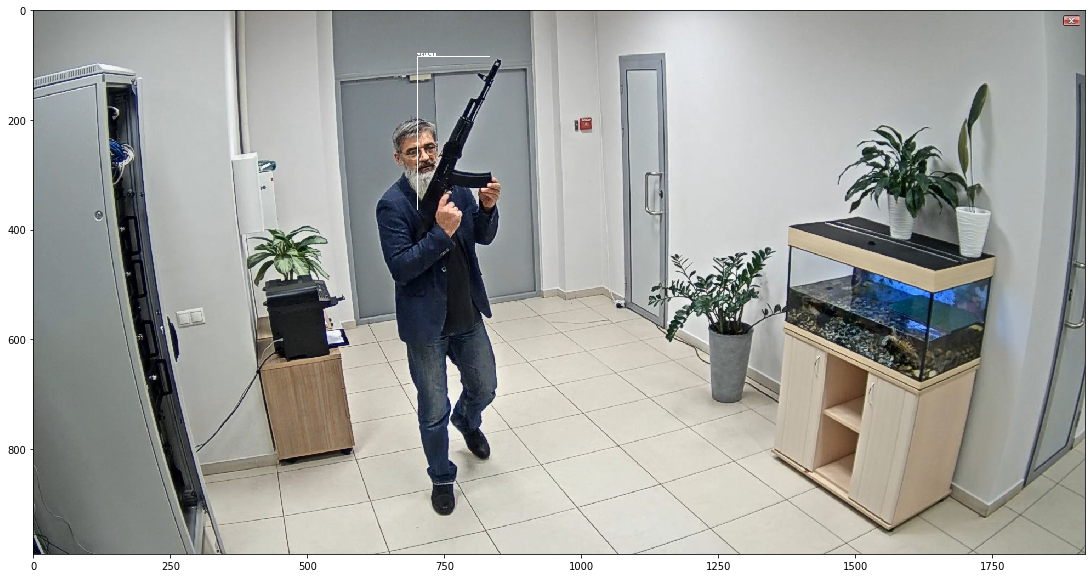

In [16]:
# Определение id классов объектов
class_name_to_id_mapping = {"weapon": 0,}

# Установка сида рандомной генерации
random.seed(0)

# Определяем словарь с id классов
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

# Функция для демонстрации разметки
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    
    # Получаем размер изображения
    w, h = image.size
    
    # Выводим исходное изображение
    plotted_image = ImageDraw.Draw(image)

    # Конвертируем координаты для показа
    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    # Вывод разметки и классов объектов
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.figure(figsize = (30,10))
    plt.imshow(np.array(image), interpolation='nearest')
    plt.show()

# Выбираем случайный файл разметки
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

# Получаем соответствующий файл с разметкой
image_file = annotation_file.replace("labels", "images").replace("txt", "jpg")
assert os.path.exists(image_file)

# Загрузка изображения
image = Image.open(image_file)

# Показ разметки
plot_bounding_box(image, annotation_list)

<div class="markdown-google-sans">

## <strong>Обучение и тестирование модели</strong>
</div>

In [17]:
# Переходим в директорию yolov5
%cd ./yolov5

/content/yolov5


In [22]:
# Запуск обучения с указанием параметров
# Измените параметры обучения так, чтобы добиться наилучших показателей

# Вы можете использовать различные модели, представленные в директории "/content/yolov5/models/"
# Информация с обучением разных моделей имеется в официальном репозитории: https://github.com/ultralytics/yolov5
# При выборе другой модели, не забудьте сменить веса для модели

#                img size  |  model config                               batch size|num of epochs |           dataset       | weights for model               |   name of model
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch-med.yaml --batch 16 --epochs 150 --data ./data/custom.yaml --weights yolov5s.pt --workers 24 --name yolo_weapon_det

#!python train.py --img 640 --batch 16 --epochs 50 --data ./data/custom.yaml --weights yolov5s.pt --cache --name yolo_weapon_det

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=./data/custom.yaml, hyp=hyp.scratch-med.yaml, epochs=150, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_weapon_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-12-g7f5724b Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, h

In [23]:
# Запуск детектирования на тестовой выборке
#!python detect.py --source ./weapon_data/images/test/ --weights runs/train/yolo_weapon_det/weights/best.pt --conf 0.25 --name yolo_weapon_det
!python detect.py --source ./weapon_data/images/test/ --weights runs/train/yolo_weapon_det/weights/best.pt --conf 0.25 --name yolo_weapon_det

detect: weights=['runs/train/yolo_weapon_det/weights/best.pt'], source=./weapon_data/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_weapon_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-12-g7f5724b Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/10 /content/yolov5/weapon_data/images/test/im16.jpg: 352x640 (no detections), 13.0ms
image 2/10 /content/yolov5/weapon_data/images/test/im2.jpg: 352x640 (no detections), 8.7ms
image 3/10 /content/yolov5/weapon_data/images/test/im31.jpg: 352x640 (no detections), 8.7ms
image 4/10 /content/yolov5/weapon_data

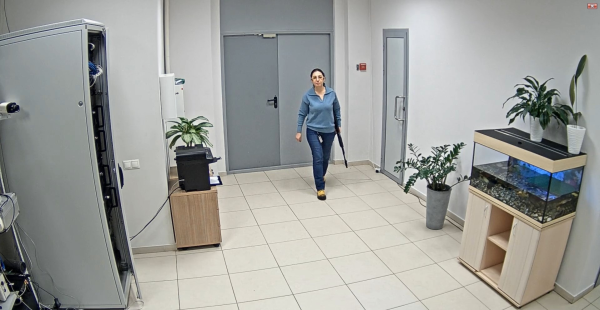

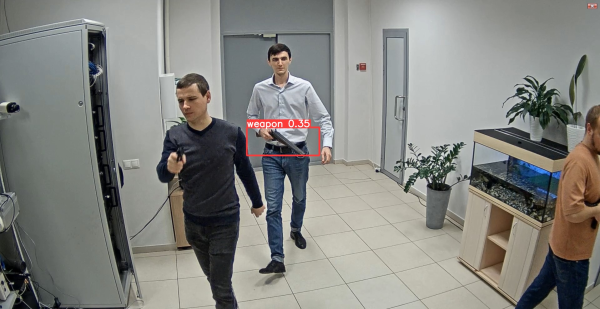

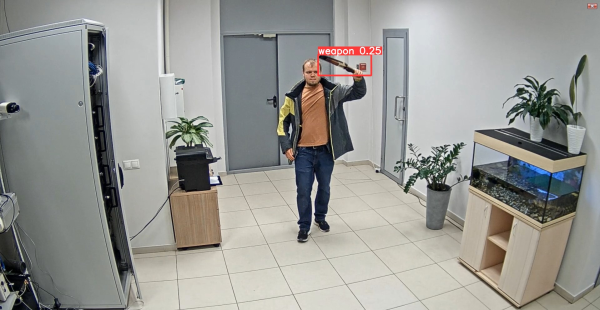

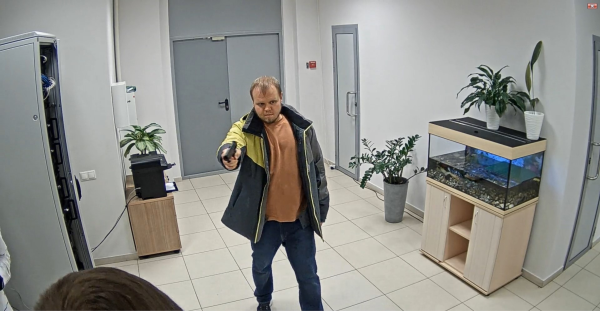

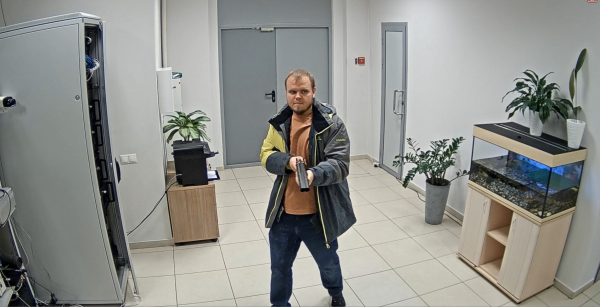

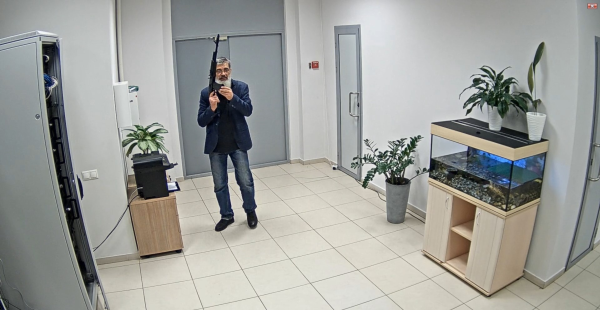

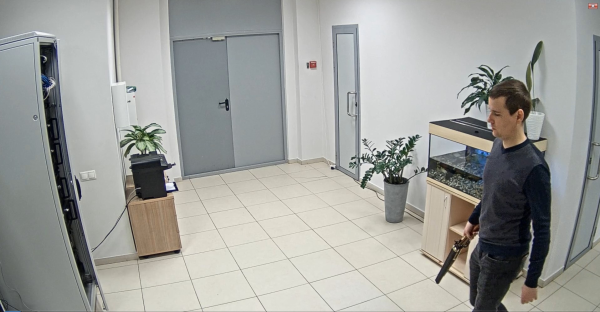

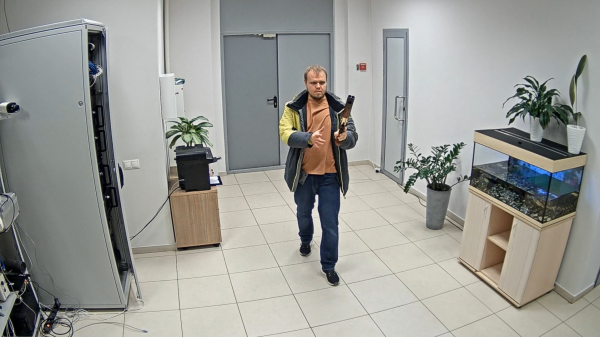

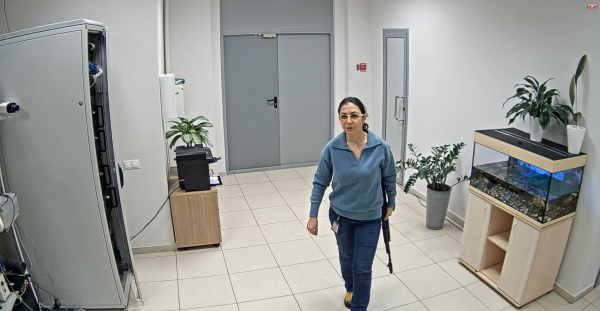

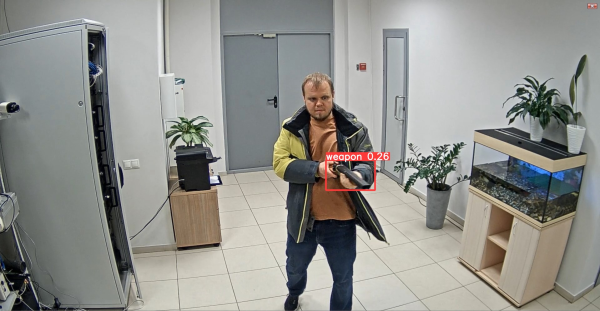

In [26]:
# Определяем путь к тестовой выборке
detections_dir = "./runs/detect/yolo_weapon_det2/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

# Вывод изображения с результатами детектирования
# random_detection_image = Image.open(random.choice(detection_images))
# plt.figure(figsize = (30,10))
# plt.imshow(np.array(random_detection_image))
for fl in os.listdir(detections_dir):
  img = cv2.imread(detections_dir+fl)
  img = imutils.resize(img, width=600)
  cv2_imshow(img)

In [25]:

# Запуск тестирования обученной модели, для получения метрик
# Результаты метрики mAP50-95 для всех классов (all) являются результатами обучения модели на тестовой выборке
print('test results:')
!python val.py --weights ./runs/train/yolo_weapon_det/weights/best.pt --data custom.yaml --task test --name yolo_weapon_det_test

test results:
val: data=/content/yolov5/data/custom.yaml, weights=['./runs/train/yolo_weapon_det/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=yolo_weapon_det_test, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-12-g7f5724b Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/yolov5/weapon_data/labels/test.cache... 10 images, 0 backgrounds, 0 corrupt: 100% 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:01<00:00,  1.60s/it]
                   all         10         11      0.833      0.453      0.604      0.232
Speed: 0.2ms pre-process, 5.6ms inference, 5.6ms NMS per im